# Galerkin Finite Element for the Poisson Equation on a Unit Bar

Solves the Poisson equation $- \frac{d^2 \, u}{dx^2} = f$ on the unit bar domain $\Omega=(0,1)$ supplied with the homogeneous Dirichlet boundary condition $u(x=0) = 0$ in the left end-point and the non-homogeneous Neumann boundary condition $u(x=1) = \alpha$ in the right end-point. 

## Install Packages

This part of the notebook can be skipped in case that all packages have been installed.

In [40]:
import Pkg
Pkg.add("Plots")
Pkg.add("BenchmarkTools")
Pkg.add("LaTeXStrings")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
   Installed BenchmarkTools ─ v1.2.0
    Updating `~/.julia/environments/v1.6/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.2.0
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.2.0
Precompiling project...
  ✓ BenchmarkTools
  1 dependency successfully precompiled in 2 seconds (299 already precompiled, 2 skipped during auto due to previous errors)
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


## Import Packages

In [41]:
using LinearAlgebra
using SparseArrays
using Plots
using LaTeXStrings
using BenchmarkTools 

## One-Dimensional Finite Element Code: Version 1 (Educational)

This version initialize the coefficient matrix as a dense matrix and assembles the matrix by a triple for-loop.

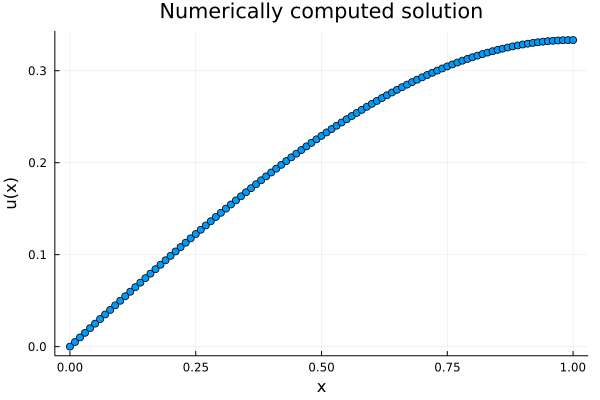

In [77]:
#..Construct an uniform mesh with N elements and mesh size h=1/N
#..Vector x holds the mesh points 
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..Mesh with edges and points
#..edges: numelem long list containing local-to-global mapping or connectivity information of each element 
#..points: numelem long list containing left and right node of each element
#..both points and edges are stored as list that are iterable 
edges = collect( [i, i+1] for i in 1:length(x)-1); 
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 

#..Set the inline source function and the value of alpha 
fsource(x) = x
alpha = 0; 

#..Define lisrt of local or element matrix and right-hand side vector using comprehension..
Aloc = collect([1 -1; -1 1]*(1/(xr-xl)) for (xl,xr) in points);
floc = collect([fsource(xl); fsource(xr)]*(xr-xl)/2 for (xl,xr) in points);

#..Initialize coefficient matrix and right-hand side vector to zero  
A = zeros(length(x), length(x)); 
f = zeros(length(x), 1); 

#..Assemble coefficient matrix and right-hand side vector by loop over the elements 
#for i=1:length(edges) for j=1:2 for k =1:2 A[edges[i][j], edges[i][k]] += Aloc[i][j,k]; end end end; 
#for i=1:length(edges) for j=1:2 f[edges[i][j]] += floc[i][j]; end end; 
for i=1:length(edges) A[edges[i], edges[i]] += Aloc[i]; end; 
for i=1:length(edges) f[edges[i]] += floc[i]; end; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1; A[1,2] = 0; f[1]     = 0; 
f[end] += alpha 
    
#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

   ## One-Dimensional Finite Element Code: Version 2 (More Performant)

This version initialize the coefficient matrix as a sparse matrix and assembles the matrix by a single for-loop.

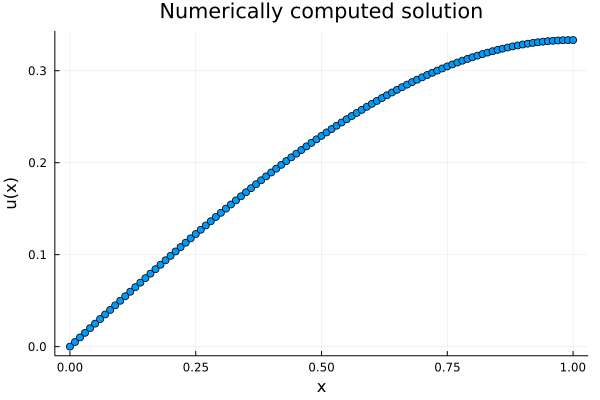

In [78]:
#..Construct an uniform mesh with N elements and mesh size h=1/N
#..Vector x holds the mesh points 
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..Mesh with edges and points
#..edges: numelem long list containing local-to-global mapping or connectivity information of each element 
#..points: numelem long list containing left and right node of each element
#..both points and edges are stored as list that are iterable 
edges = collect( [i, i+1] for i in 1:length(x)-1); 
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 

#..Set the inline source function and the value of alpha 
fsource(x) = x
alpha = 0; 

#..Define lisrt of local or element matrix and right-hand side vector using comprehension..
Aloc = collect([1 -1; -1 1]*(1/(xr-xl)) for (xl,xr) in points);
floc = collect([fsource(xl); fsource(xr)]*(xr-xl)/2 for (xl,xr) in points);

#..Initialize coefficient matrix and right-hand side vector to zero  
A = spzeros(length(x), length(x)); 
f = zeros(length(x), 1); 

#..Assemble coefficient matrix and right-hand side vector by loop over the elements 
for i=1:length(edges) A[edges[i], edges[i]] += Aloc[i]; end; 
for i=1:length(edges) f[edges[i]] += floc[i]; end; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1; A[1,2] = 0; f[1]     = 0; 
f[end] += alpha 
    
#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

## One-Dimensional Finite Element Code: Version 3: Using Functional Programming

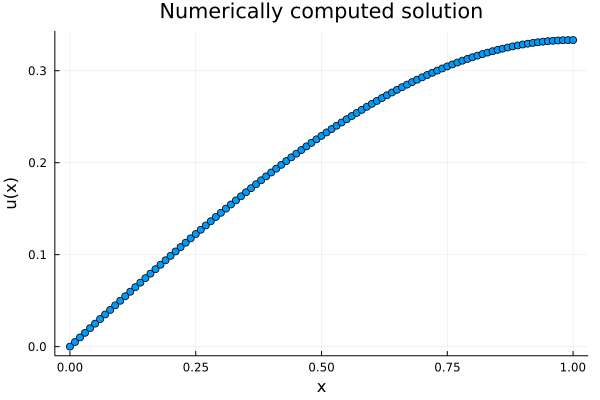

In [79]:
#..Define struct to hold for each element, x-coordinate and global numbering  
struct Element 
  p1::Int
  p2::Int
  x1::Float64
  x2::Float64 
end 

#..Set number of elements and mesh width 
N = 100; h = 1/N;

#..Define the vector holding all the nodes 
x = Vector(0:h:1); 

#..Set the inline source function and the value of alpha 
fsource(x) = x
alpha = 0; 

#..Generate the mesh using comprehensions
mesh = [Element(i, i+1, (i-1)*h, i*h ) for i in 1:N];

#..function to generate the elementary matrix 
function elemMat(Element)
  return 1/(Element.x2 - Element.x1)*[1.; -1.; -1.; 1.];
end 

#..function to generate the elementary vector  
function elemVec(Element)
  return (Element.x2 - Element.x1)/2*[fsource(Element.x1); fsource(Element.x2)];
end 

#..function to generate row index 
function rowIndex(Element)
       return [Element.p1; Element.p1; Element.p2; Element.p2]
end

#..function to generate column index 
function colIndex(Element)
       return [Element.p1; Element.p2; Element.p1; Element.p2]
end

#..function to generate row index 
function rowVecIndex(Element)
       return [Element.p1 ; Element.p2]
end

#..Generate matrix values 
valsaux = map(elemMat, mesh); valsMat = reduce(vcat, valsaux);  
valsaux = map(elemVec, mesh); valsVec = reduce(vcat, valsaux);  

#..Generate row indices 
Iaux = map(rowIndex, mesh); I = reduce(vcat, Iaux);  

#..Generate column indices
Jaux = map(colIndex, mesh); J = reduce(vcat, Jaux); 

#..Generate row indices 
Iaux = map(rowVecIndex, mesh); IVec = reduce(vcat, Iaux);  

#..Assemble the matrix and right-hand side vector 
A = sparse(I, J, valsMat);
f = Vector(sparsevec(IVec, valsVec));

if (false) spy(A, ms=5) end 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1; A[1,2] = 0; f[1] = 0; 
f[end] += alpha 

#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

## One-Dimensional Finite Element Code: Version 4 (Experimental using Functional Programming)

Our is to simplify the code of Version-3. We wish to obtain a all relevabt data from a single map over the elemen ts of the mesh. 

Small exmaple on the use of splatting. For splatting and slurping, see the manual at [splatting/slurping](https://docs.julialang.org/en/v1/manual/faq/#What-does-the-...-operator-do?). 

In [38]:
f1(x) = [1;1]
g1(x) = x*[1;1]
h1(x) = [1;1], x*[1;1]
ff = mapreduce(f1,vcat,[1 2 3])
gg = mapreduce(g1,vcat,[1 2 3])
hh = map(h1, [1 2 3])
fff,ggg = vcat.(hh...) # here the symbol ... refers to splatting 

([1, 1, 1, 1, 1, 1], [1, 1, 2, 2, 3, 3])

In [ ]:
#..construct the mesh
N = 3; Np1 = N+1; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points (p) and edges (e) 
p = [ x[1:end-1] x[2:end] ]
e = [ 1:N 2:N+1]

#..Set the source function 
fsource(x) = x*(x-1); 

#..function to compute local matrix contributions.. 
function compute_elem_area(elem_id, p, e)
  area = p[elem_id,2] - p[elem_id,1]
  return [1 1]
end

map([1:N]) do elem_id 
    compute_elem_area(elem_id, p, e)
end

#..function to compute local matrix contributions.. 
function compute_elem_mat(elem_id, p, e)
  area = p[elem_id,2] - p[elem_id,1]
  elemI = [ e[elem_id,1] e[elem_id,1] e[elem_id,2] e[elem_id,2] ] 
  elemJ = [ e[elem_id,1] e[elem_id,2] e[elem_id,1] e[elem_id,2] ]
  elemA = area*[1 -1 -1 1]
  return elemI, elemJ, elemA 
end

map(elem_ids) do elem_id 
    compute_elem_area(elem_id, e, p)
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;                 A[1,2] = 0;            f[1]     = 0; 
A[end,end-1]=0;     A[end,end] = 1;    f[end] = 0;
# A[end,end-1]=-1; A[end,end] = 1;       f[end] = 10;  

#..solve the linear system
u = A \ f; 

#..plot the solution  
plot(x,u)